## Association between gene expression and subtype or grade
### (Brain Lower Grade Glioma) 

In [3]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)
%matplotlib inline

## Gene Data Preprocessing

In [4]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head(3)

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707


In [5]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail(3)

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [6]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")

There are 514 samples in total, and there are 20531 genes in total.


In [7]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: True
There are 0 columns with the same value.
[]...


In [8]:
# remove any genes that contain NaN
cols = list(df_clean.columns[~df_clean.isnull().any()])
df_clean_1 = df_clean[cols]

In [9]:
# thus, we need to drop all of same_value_cols: 
df_clean_1 = df_clean_1.drop(same_value_cols, axis = 1)

## Clinical Patient Data Preprocessing

In [10]:
## read patient data and preprocessing...
raw_data_sample = pd.read_table("./data/data_clinical_sample.txt", sep="\t")
df_sample2 = pd.read_table("./supplement_data/Clinical_Data.tsv", sep="\t")
raw_data_sample.columns = raw_data_sample.iloc[3,:]
raw_data_sample = raw_data_sample.drop([0,1,2,3], axis = 0)
df_patient = raw_data_sample.reset_index().drop(["index"], axis = 1)
df_full = df_patient.merge(df_sample2, left_on = "PATIENT_ID", right_on = "Patient ID", how = "left")
df_full_1 = df_full.drop(['Patient ID', 'Sample ID','Cancer Type Detailed','Tumor Type', 'Aneuploidy Score'], axis = 1)

## Creating anndata with sample as its obs:

In [11]:
df_sample_with_gene = df_clean_1.merge(df_full_1, left_index=True, right_on = "SAMPLE_ID")
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [12]:
X = df_sample_with_gene.iloc[:,0:-30].copy()
X = X.set_index("PATIENT_ID")
obs = df_sample_with_gene.iloc[:,-31:].copy()
obs = obs.set_index("PATIENT_ID")
adata_sample = sc.AnnData(X, obs = obs)

In [42]:
sc.tl.pca(adata_sample, svd_solver = "arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


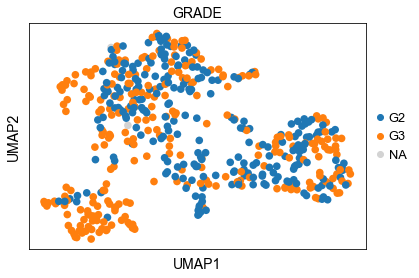

In [43]:
sc.pp.neighbors(adata_sample, n_neighbors=5)
sc.tl.umap(adata_sample, min_dist=0.3)
sc.pl.umap(adata_sample, color = ["GRADE"])

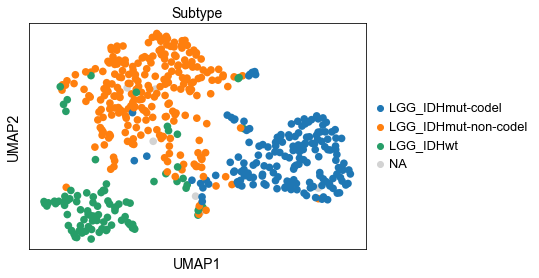

In [44]:
sc.pl.umap(adata_sample, color = ["Subtype"])

## TCGA researchers learned about lower grade glioma?

Reference: https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga/studied-cancers/glioma

Mutations and chromosomal alterations define three lower grade glioma subtypes with distinct clinical outcomes: 

1. IDH mutant and 1p/19q co-deletion:

* The 1p/19q abnormality consists of deletion of a short arm of chromosome 1 and longer arm of chromosome 19.

* Mutations in IDH1 and IDH2, isocitrate dehydrogenases, lead to abnormal enzyme activity, hypermethylation, and deviant gene expression.

* This subtype is associated with the most favorable prognosis.

2. IDH mutant without 1p/19q co-deletion, associated with intermediate prognosis



3. IDH wild-type, associated with the poorest outcomes

IDH wild-type subtype shares genomic markers and similar clinical outcomes with glioblastomas, indicating that this subtype of lower grade glioma may be a precursor to the more aggressive counterpart.


Molecular signatures and subtypes may inform the classification, diagnosis, and treatment of lower grade gliomas:

* Lower grade gliomas without IDH mutations may benefit from treatment with protocols adapted from current glioblastoma treatments.

* Recently developed therapies may target the aberrant activity of IDH1/2 proteins in lower grade glioma.


In [38]:
gene_symbol_id.loc[(gene_symbol_id.Hugo_Symbol == "IDH1") | (gene_symbol_id.Hugo_Symbol == "IDH2")]

,Hugo_Symbol,Entrez_Gene_Id
8233,IDH1,3417
8234,IDH2,3418


## Association between glioma subtype and gene expression? 

**Summary:**  

According to following models, we found that gene expression level would have highly correlation with the subtype of Brain Lower Grade Glioma. We could predict the subtype of BLGG based on the level of expression. 

In [13]:
# preprocessing the data: encode, drop nan, scale? 
X= pd.DataFrame(adata_sample.X)
X.columns = adata_sample.var_names
X.index = adata_sample.obs.index
y = adata_sample.obs['Subtype']
df = pd.concat([X,y], axis = 1)

In [14]:
df_drop = df.drop(df[df.Subtype.isnull()].index, axis = 0)

In [15]:
# assign features, target and encoding...
y = df_drop["Subtype"]
X= df_drop.drop("Subtype", axis = 1)

y = y.map({"LGG_IDHmut-non-codel":0, "LGG_IDHwt":1, "LGG_IDHmut-codel":2})

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [17]:
print(f"There are totally {len(X_test)} samples in test set.")

There are totally 127 samples in test set.


In [48]:
# using random forest classifier as the predicting model: 
from sklearn.ensemble import RandomForestClassifier 
rf = RandomForestClassifier(warm_start = True, n_estimators = 100)
rf.fit(X_train,y_train)
print(f"The training set accuracy score: {rf.score(X_train,y_train)}")
print(f"The test set accuracy score: {rf.score(X_test,y_test)}")

The training set accuracy score: 1.0
The test set accuracy score: 0.984251968503937


In [49]:
# F1-score, precision & recall 
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        64
           1       1.00      0.90      0.95        21
           2       1.00      1.00      1.00        42

    accuracy                           0.98       127
   macro avg       0.99      0.97      0.98       127
weighted avg       0.98      0.98      0.98       127



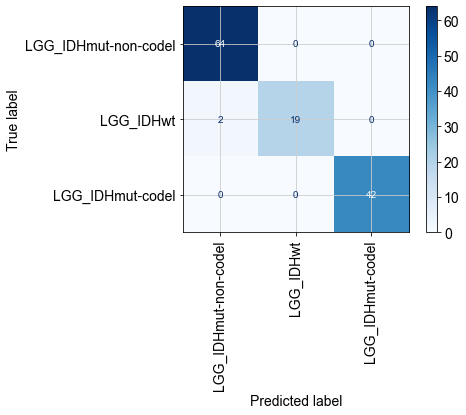

In [50]:
# confusion matrix 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
disp = plot_confusion_matrix(rf, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')

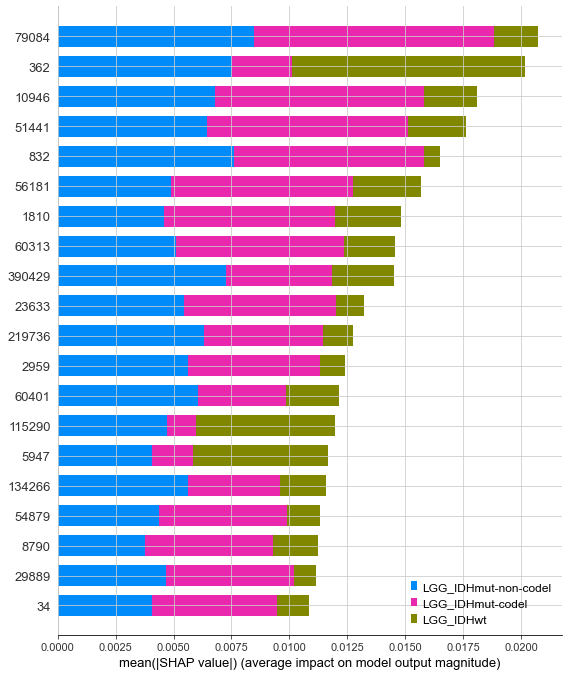

In [51]:
# feature importance inspection 
import shap 
explainer = shap.TreeExplainer(rf)
shap_valuesfor = explainer.shap_values(X)

class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_valuesfor, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

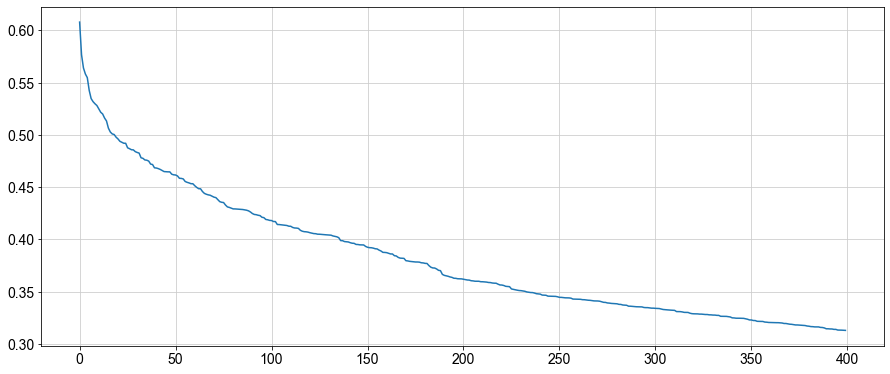

In [18]:
from sklearn.feature_selection import mutual_info_classif
# create a dataframe containing mutual information for each feature
midf = pd.DataFrame({
    "feature": X_train.columns.values,
    "mi": mutual_info_classif(X_train, y_train),
}).sort_values("mi", ascending=False)
import matplotlib.pyplot as plt
import numpy as np
f, _ = plt.subplots(figsize = (15, 6))
plt.plot(np.arange(400), midf.mi.iloc[:400])

In [19]:
selected_genes = midf.loc[midf.mi >= 0.41, "feature"]
len(selected_genes)

115

In [21]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# set random seed for reproducibility
np.random.seed(4060)
lr = LogisticRegression(penalty='l1', multi_class='multinomial', solver='saga')
lr.fit(X_train[selected_genes], y_train)
lr.score(X_train[selected_genes], y_train)

0.9868421052631579

In [22]:
y_pred_score = lr.predict_proba(X_test[selected_genes])

# use predict function to directly ask model to output the
# predicted class

y_pred = lr.predict(X_test[selected_genes])
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }
performance_scores(y_test, y_pred_score, y_pred)

{'accuracy': 0.984251968503937,
 'balanced_accuracy': 0.9682539682539683,
 'auroc': 1.0,
 'f1': 0.9839794064203513}

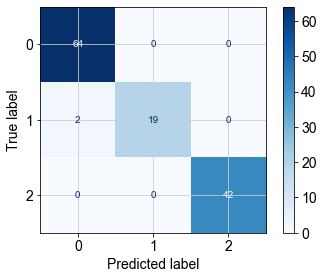

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=lr.classes_)
disp.plot(cmap="Blues")

In [34]:
df_gene_reference = pd.read_table("./supplement_data/gene_table.tsv")
#df_gene_reference["NCBI GeneID"] = df_gene_reference["NCBI GeneID"].astype("str")

In [35]:
df_selected_genes = pd.DataFrame(selected_genes)
df_selected_genes = df_selected_genes.merge(df_gene_reference, left_on = "feature", right_on = "NCBI GeneID", how = "left")

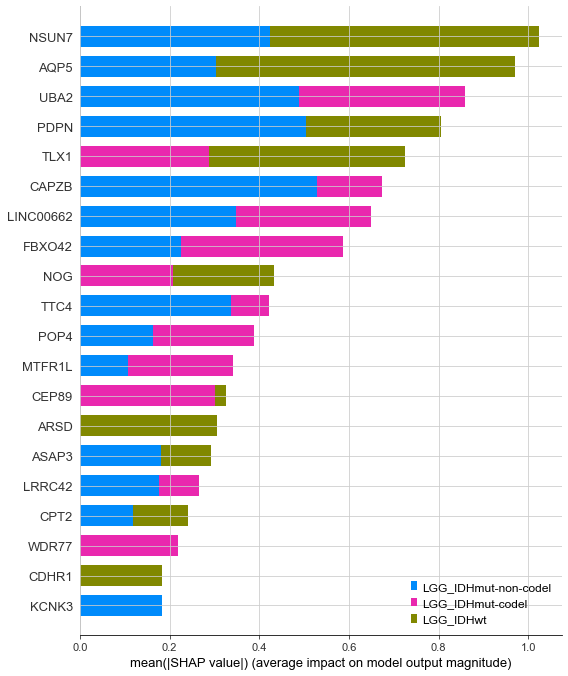

In [38]:
import shap
X_train = X_train[selected_genes]
X_test = X_test[selected_genes]

explainer = shap.Explainer(lr, X_train, feature_names=X.columns)
shap_values = explainer.shap_values(X_test)

# get the table for feature_importance
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns, sum(vals))), columns=['gene_id','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance = feature_importance.reset_index(drop=True)

# the plot for the data
class_names = ["LGG_IDHmut-non-codel", "LGG_IDHwt", "LGG_IDHmut-codel"]
shap.summary_plot(shap_values, X_train.values, plot_type="bar", class_names= class_names, feature_names = df_selected_genes.Symbol)

In [41]:
important_gene = feature_importance.merge(df_selected_genes, how = "left", left_on = "gene_id", right_on = "feature").drop(["feature", "NCBI GeneID"], axis = 1)
important_gene.head(10)

,gene_id,feature_importance_vals,Symbol,Description,Taxonomic Name,Gene Type,Gene Group Identifier,Gene Group Method
0,79730,43.297802,NSUN7,NOP2/Sun RNA methyltransferase family member 7,Homo sapiens,PROTEIN_CODING,79730.0,NCBI Ortholog
1,362,41.029766,AQP5,aquaporin 5,Homo sapiens,PROTEIN_CODING,362.0,NCBI Ortholog
2,10054,36.331856,UBA2,ubiquitin like modifier activating enzyme 2,Homo sapiens,PROTEIN_CODING,10054.0,NCBI Ortholog
3,10630,34.106667,PDPN,podoplanin,Homo sapiens,PROTEIN_CODING,10630.0,NCBI Ortholog
4,3195,30.653908,TLX1,T cell leukemia homeobox 1,Homo sapiens,PROTEIN_CODING,3195.0,NCBI Ortholog
5,832,28.498119,CAPZB,capping actin protein of muscle Z-line subunit...,Homo sapiens,PROTEIN_CODING,832.0,NCBI Ortholog
6,148189,27.476168,LINC00662,long intergenic non-protein coding RNA 662,Homo sapiens,ncRNA,NaN,NaN
7,54455,24.842926,FBXO42,F-box protein 42,Homo sapiens,PROTEIN_CODING,54455.0,NCBI Ortholog
8,9241,18.294868,NOG,noggin,Homo sapiens,PROTEIN_CODING,9241.0,NCBI Ortholog
9,7268,17.873714,TTC4,tetratricopeptide repeat domain 4,Homo sapiens,PROTEIN_CODING,7268.0,NCBI Ortholog
